In [1]:
from common import colors, fliersize, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statannot import add_stat_annotation
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))

In [5]:
_paths = {
    'RT': os.path.join(os.getenv('DATA_PATH'), 'models', '5HT'),
    '29C-30C': os.path.join(os.getenv('DATA_PATH'), 'models', '5HT_heated'),
}
_benchmark_labels = {
    'Md_8': '$M_d^*$',
    'R2_V': '$R^2$ on $V$',
    'R2_dV': '$R^2$ on $dV/dt$',
}
_model_labels = {
    '5HT_GIFs': 'GIF',
    '5HT_AugmentedGIFs': 'aGIF',
    '5HT_iGIF_VRs': 'iGIF VR',
    '5HT_iGIF_NPs': 'iGIF NP',
}
_benchmark_tables = []
for temperature in _paths:
    for bench, label in _benchmark_labels.iteritems():
        _table = pd.read_csv(
            os.path.join(
                _paths[temperature],
                '5HT_goodcellsbenchmark_{}.csv'.format(bench),
            )
        )
        _table['benchmark_type'] = bench
        _table['benchmark_label'] = label
        _table['temperature'] = temperature
        _table.rename(_model_labels, inplace=True, axis='columns')
        _benchmark_tables.append(_table)
benchmarks = pd.concat(_benchmark_tables, ignore_index=True).melt(
    value_vars=_model_labels.values(),
    id_vars=['temperature', 'benchmark_type', 'benchmark_label', 'cell_id'],
    var_name='model_label',
    value_name='benchmark_value',
)
del (
    _paths,
    _benchmark_labels,
    _benchmark_tables,
    temperature,
    bench,
    label,
    _table,
)
benchmarks.head()

,temperature,benchmark_type,benchmark_label,cell_id,model_label,benchmark_value
0,RT,R2_V,$R^2$ on $V$,DRN307,GIF,0.955310
1,RT,R2_V,$R^2$ on $V$,DRN308,GIF,0.905802
2,RT,R2_V,$R^2$ on $V$,DRN317,GIF,0.944195
3,RT,R2_V,$R^2$ on $V$,DRN318,GIF,0.925228
4,RT,R2_V,$R^2$ on $V$,DRN319,GIF,0.681506


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
('Using zero_method ', 'pratt')
GIF_29C-30C v.s. aGIF_29C-30C: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.110e-02 stat=3.600e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
('Using zero_method ', 'pratt')
GIF_29C-30C v.s. aGIF_29C-30C: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.964e-04 stat=0.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
('Using zero_method ', 'pratt')
GIF_29C-30C v.s. aGIF_29C-30C: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.810e-04 stat=3.000e+00
('Using zero_method ', 'pratt')
aGIF_29C-30

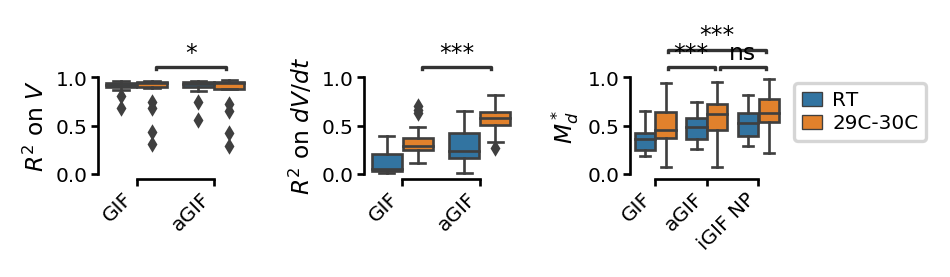

In [19]:
_cell_ids = (
    benchmarks.query('temperature == "29C-30C"')['cell_id']
    .to_numpy()
    .reshape((-1, 18))
)
assert (_cell_ids == _cell_ids[0, :]).all(), (
    'cell_id is not consistently ordered across models, '
    'results of paired statistical tests may be incorrect.'
)

fig, axes = plt.subplots(
    1, len(benchmarks['benchmark_label'].unique()), figsize=(4, 1)
)

for ax, bench in zip(axes, benchmarks['benchmark_label'].unique()):
    ax.set_ylim(-0.05, 1.05)
    if bench.startswith('$R^2$'):
        models_to_compare = ['GIF', 'aGIF']
        tests = [
            (('GIF', '29C-30C'), ('aGIF', '29C-30C')),
        ]
    else:
        models_to_compare = ['GIF', 'aGIF', 'iGIF NP']
        tests = [
            (('GIF', '29C-30C'), ('aGIF', '29C-30C')),
            (('GIF', '29C-30C'), ('iGIF NP', '29C-30C')),
            (('aGIF', '29C-30C'), ('iGIF NP', '29C-30C')),
        ]
    d = benchmarks.query(
        'benchmark_label == @bench '
        'and model_label in @models_to_compare'
    )
    sns.boxplot(
        x='model_label',
        y='benchmark_value',
        hue='temperature',
        data=d,
        ax=ax,
        fliersize=fliersize,
    )
    add_stat_annotation(
        ax,
        'boxplot',
        x='model_label',
        y='benchmark_value',
        hue='temperature',
        data=d,
        box_pairs=tests,
        test='Wilcoxon',
        linewidth=1,
        fontsize=7,
        loc='outside',
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel(bench)
    ax.set_xlabel('')
    ax.legend().remove()
    pltools.hide_border('tr', trim=True, ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

try:
    savefig(
        os.path.join(
            os.getenv('IMG_PATH'), 'ser_model_benchmark_temp_comparison'
        )
    )
finally:
    plt.show()
    fig.clf()
    plt.close(fig)

In [20]:
d.groupby(['model_label', 'temperature']).count()

benchmark_type  benchmark_label  cell_id  \
model_label temperature                                             
GIF         29C-30C                  18               18       18   
            RT                       18               18       18   
aGIF        29C-30C                  18               18       18   
            RT                       18               18       18   
iGIF NP     29C-30C                  18               18       18   
            RT                       18               18       18   

                         benchmark_value  
model_label temperature                   
GIF         29C-30C                   18  
            RT                        18  
aGIF        29C-30C                   18  
            RT                        18  
iGIF NP     29C-30C                   18  
            RT                        18